### Spatial Transformer Networks (NIPS 2015, DeepMind)

-  CNN are not invariant to spatial transformations of the input data, (somewhat invariant to translation due to max pooling, but still)
-  They introduce the Spatial Transformer module, that can be included into a standard neural network. The action of the spatial transformer is conditioned on individual data samples. 
- The transformation is then performed on the entire feature map (non-locally) and can include scaling, cropping, rotations, as well as non-rigid deformations.
- This allows networks to not only **select** regions that are most relevant (attention), but also to **transform** those regions.

<img src=attachment:image.png width=600>
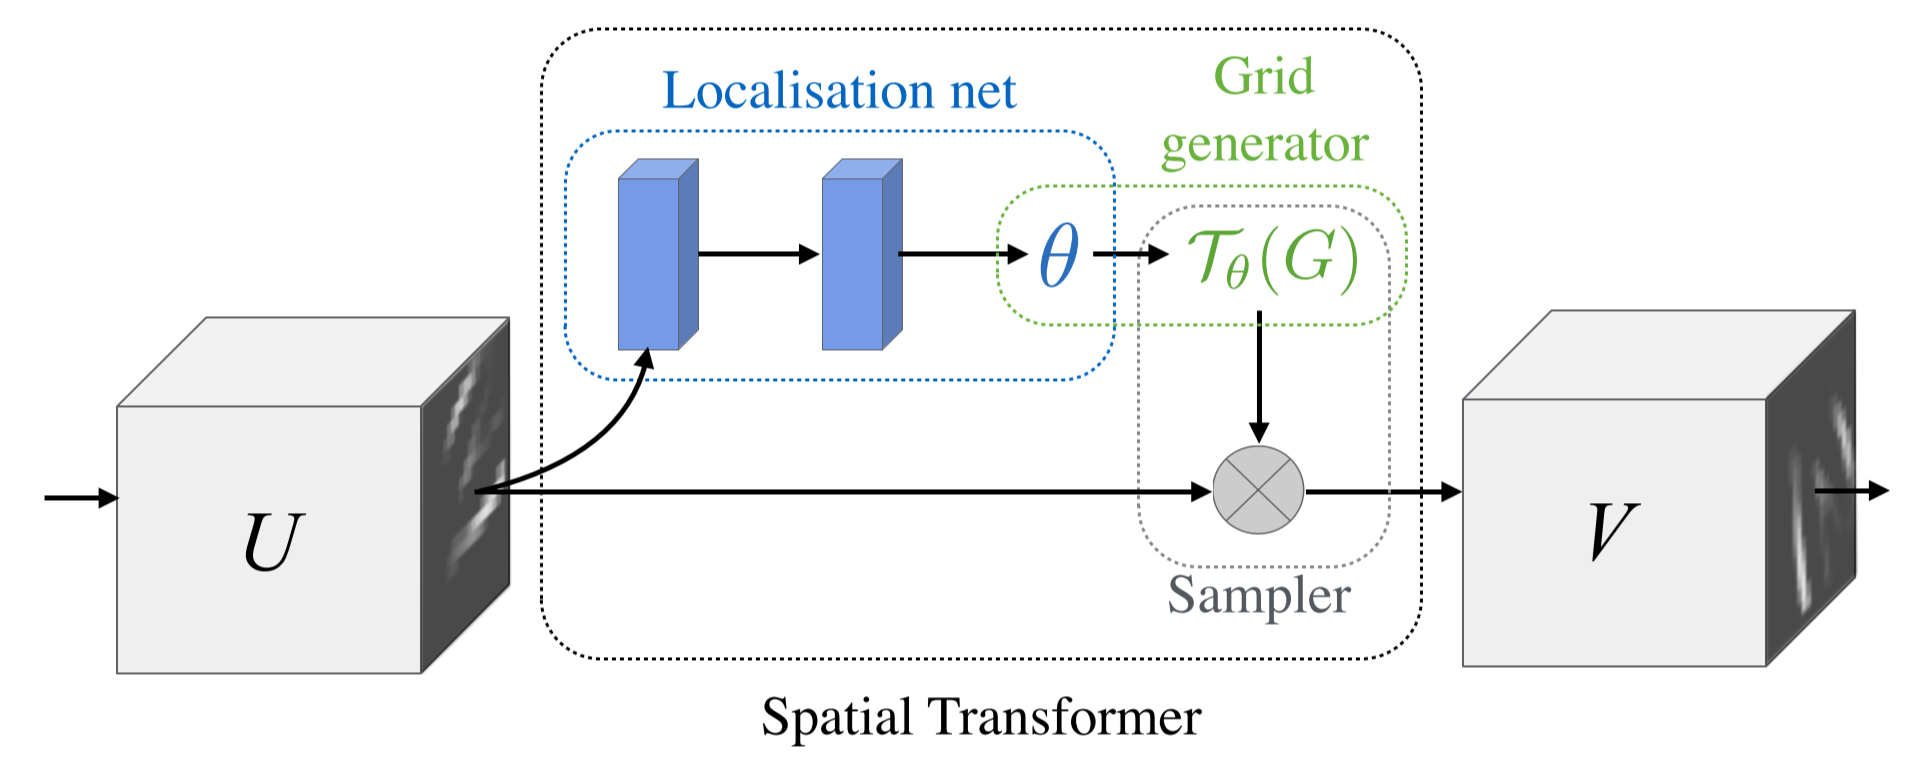

- 2D affine transformation case:
\begin{align} \begin{pmatrix} x_i^s \\ y_i^s \end{pmatrix} = \mathcal{T}_{\theta}(G_i) = \mathtt{A}_\theta \begin{pmatrix} x_i^t \\ y_i^t \\ 1 \end{pmatrix} = \begin{bmatrix} \theta_{11} \,\; \theta_{12} \,\, \theta_{13} \\ \theta_{21} \,\; \theta_{22} \,\; \theta_{23} \end{bmatrix} \begin{pmatrix} x_i^t \\ y_i^t \\ 1 \end{pmatrix} \end{align}
- The grid generator's job is to output a parametrised sampling grid, which is a set of points where the input map **should** be sampled to produce the desired transformed output.
    - However results are float numbers, thus we do bilinear interpolation. (Since bilinear interpolation is differentiable, it is perfectly suitable)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

- examples

In [21]:
it = iter(train_loader)
batch, label = next(it)

In [22]:
batch = batch.to(device)
batch.shape

torch.Size([64, 1, 28, 28])

In [23]:
out = model.localization(batch)
print(out.shape)
out = out.view(-1, 10 * 3 * 3)
theta = model.fc_loc(out)
print(theta.shape)
theta = theta.view(-1, 2, 3)

torch.Size([64, 10, 3, 3])
torch.Size([64, 6])


- F.affine_grid
- Generates a 2d flow field, given a batch of affine matrices, $\theta$
    - Generally used in conjunction with : *grid_sample* to implement Spatial Transformer Networks. 

In [24]:
grid = F.affine_grid(theta, batch.size())

In [74]:
x = F.grid_sample(batch, grid)

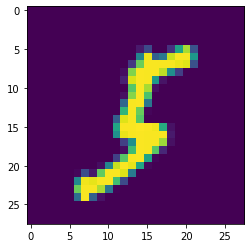

In [98]:
plt.imshow(batch[31].cpu().detach().reshape([28,28]))

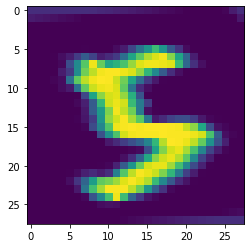

In [99]:
img = x[31].cpu().detach().numpy()
img = img.reshape([28,28])
plt.imshow(img)

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [14]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

In [15]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311909
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.146014


/home/parkchanwoo/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3031, Accuracy: 9114/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.703973
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.398850

Test set: Average loss: 0.1514, Accuracy: 9548/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.378454
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.285373

Test set: Average loss: 0.1165, Accuracy: 9627/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.139660
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.157596

Test set: Average loss: 0.0917, Accuracy: 9721/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.093713
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.134712

Test set: Average loss: 0.1450, Accuracy: 9575/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.224503
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.266699

Test set: Average loss: 0.0709, Accuracy: 9786/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.201688
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.216603

Test set: Average loss: 0.0571, Accuracy: 9813/10000 (98%)

Tra

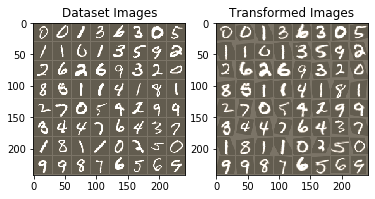

In [16]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()